In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('data.pickle', 'rb') as k:
    data=pickle.load(k)

#Time
time=data['t']

#Initial states
x_initial=data['x_init']
y_initial=data['y_init']
theta_initial=data['th_init']

#Inputs
tra_v =data['v']
rot_v=data['om']
input_variance=np.diag([data['v_var'], data['om_var'],1])

#LIDAR
bearing=data['b']  
rang=data['r']  
landmark=data['l']  
distance=data['d']  
measure_var=np.diag([data['r_var'], data['b_var']]) 

state=np.zeros([len(time),3])
covariance=np.zeros([len(time),3,3])

state[0]=np.array([x_initial,y_initial,theta_initial])
covariance[0]=np.diag([1,1,0.1])
def wrapangle(x):
    return np.arctan2(np.sin(float(x)),np.cos(float(x)))

In [2]:
def measurement_update(landmark2,rang2,bearing2,cov_check,state_check):
    
    x_check=state_check[0]
    y_check=state_check[1]
    theta_check=wrapangle(state_check[2])
    
    x_landmark=landmark2[0]
    y_landmark=landmark2[1]
    
    x1=float(x_landmark-x_check-distance*np.cos(theta_check))
    y1=float(y_landmark-y_check-distance*np.sin(theta_check))
    q=float(np.sqrt(x1**2+y1**2))
    theta=np.arctan2(y1,x1)-theta_check
    
    #Jacobian for measurement
    k=float(distance*(x1*np.sin(theta_check)-y1*np.cos(theta_check))/q)
    j=float(-1-distance*(y1*np.sin(theta_check)+x1*np.cos(theta_check))/q**2)
    h=np.array([[-x1/q, -y1/q,k],[y1/q**2,-x1/q**2,j]])

    observed=np.array([[q],[wrapangle(theta)]])
    measured=np.array([[rang2],[wrapangle(bearing2)]])
    
    #Kalman Gain
    kalman=cov_check.dot(h.T).dot(np.linalg.inv(h.dot(cov_check).dot(h.T)+measure_var))
    
    #Corrected State and covariance
    state_check=state_check + kalman.dot(measured-observed)
    state_check[2]=wrapangle(state_check[2])
    cov_check=(np.identity(3)-kalman.dot(h)).dot(cov_check)
    
    return state_check, cov_check

In [3]:
cov_check = covariance[0]
state_check = state[0, :].reshape(3,1)
for a in range(1, len(time)):

    delta_t=time[a]-time[a-1]
    theta=wrapangle(state_check[2])
    
    #Motion Model
    k=tra_v[a-1]/rot_v[a-1]
    motion=np.matrix([[-k*np.sin(theta)+k*np.sin(theta+rot_v[a-1]*delta_t)],
                 [k*np.cos(theta)-k*np.cos(theta+rot_v[a-1]*delta_t)],
                 [rot_v[a-1]*delta_t]])
    state_check=state_check+motion
    state_check[2]=wrapangle(state_check[2])

    #Jacobian for motion model
    g=np.matrix([[1, 0, -k*np.cos(theta)+k*np.cos(theta+rot_v[a-1]*delta_t)],
                 [0, 1,-k*np.sin(theta)+k*np.sin(theta+rot_v[a-1]*delta_t)],
                 [0, 0, 1]])

    #Calculating new covariance
    cov_check=g.dot(cov_check.dot(g.T))+input_variance 

    for i in range(len(rang[a])):
        state_check,cov_check=measurement_update(landmark[i],rang[a,i],bearing[a,i],cov_check,state_check)

    state[a,0]=state_check[0]
    state[a,1]=state_check[1]
    state[a,2]=state_check[2]
    covariance[a,:,:]=cov_check
    

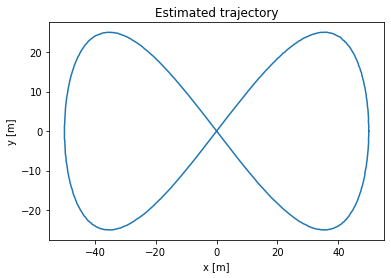

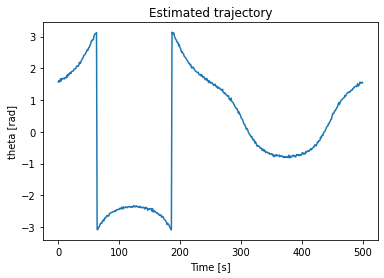

In [4]:
e_fig=plt.figure()
ax=e_fig.add_subplot(111)
ax.plot(state[:, 0], state[:, 1])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Estimated trajectory')
plt.show()

e_fig=plt.figure()
ax=e_fig.add_subplot(111)
ax.plot(time[:], state[:, 2])
ax.set_xlabel('Time [s]')
ax.set_ylabel('theta [rad]')
ax.set_title('Estimated trajectory')
plt.show()

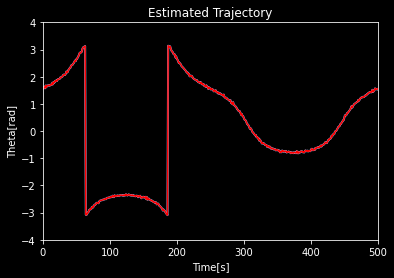

In [40]:
import matplotlib.animation as animation  
plt.style.use('seaborn-pastel')

fig = plt.figure() 
ax = plt.axes(xlim=(0, 500), ylim=(-4, 4)) 
line, = ax.plot([], [], lw=2)
ax.plot(time,state[:,2],color='red')

def init(): 

    line.set_data([], []) 
    return line, 

xdata, ydata = [], [] 

def animate(i): 

    xdata.append(i) 
    ydata.append(state[i,2]) 
    line.set_data(xdata, ydata) 
    return line, 


plt.xlabel('Time[s]')
plt.ylabel('Theta[rad]')
plt.title('Estimated Trajectory') 


anim = animation.FuncAnimation(fig, animate, init_func=init, 
							frames=500, interval=20, blit=True) 
anim.save('ekf_theta_vs_time.gif',writer='imagemagick') 

In [ ]:
plt.style.use('seaborn-pastel')

fig = plt.figure() 
ax = plt.axes(xlim=(0, 500), ylim=(-4, 4)) 
line, = ax.plot([], [], lw=2)
ax.plot(time,state[:,2],color='red')

def init(): 

    line.set_data([], []) 
    return line, 

xdata, ydata = [], [] 

def animate(i): 

    xdata.append(state[i,0]) 
    ydata.append(state[i,1]) 
    line.set_data(xdata, ydata) 
    return line, 


plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.title('Estimated Trajectory') 


anim = animation.FuncAnimation(fig, animate, init_func=init, 
							frames=500, interval=20, blit=True) 
anim.save('ekf_y_vs_x.gif',writer='imagemagick') 